In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(precision=2); np.random.seed(0)
import torch; torch.set_printoptions(precision=2)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt
# import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
# from mpltern.ternary.datasets import get_scatter_points


import seaborn as sns
import time
import sys
import itertools 
import random; random.seed(0)
import datetime
import pickle
import copy
import pandas as pd
import scipy; from scipy import stats; from scipy.stats import wilcoxon
import os

from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import sys

# from model_working import *
from functions import *

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

2.5.1
3.10.16 (main, Dec 11 2024, 10:24:41) [Clang 14.0.6 ]


# Figure 5c: bias in the input weight, one example model

/var/folders/wl/qh_kqt7x4lldx3dnln90l7c80000gn/T/ipykernel_66072/1215102789.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  all_data = pickle.load(handle)


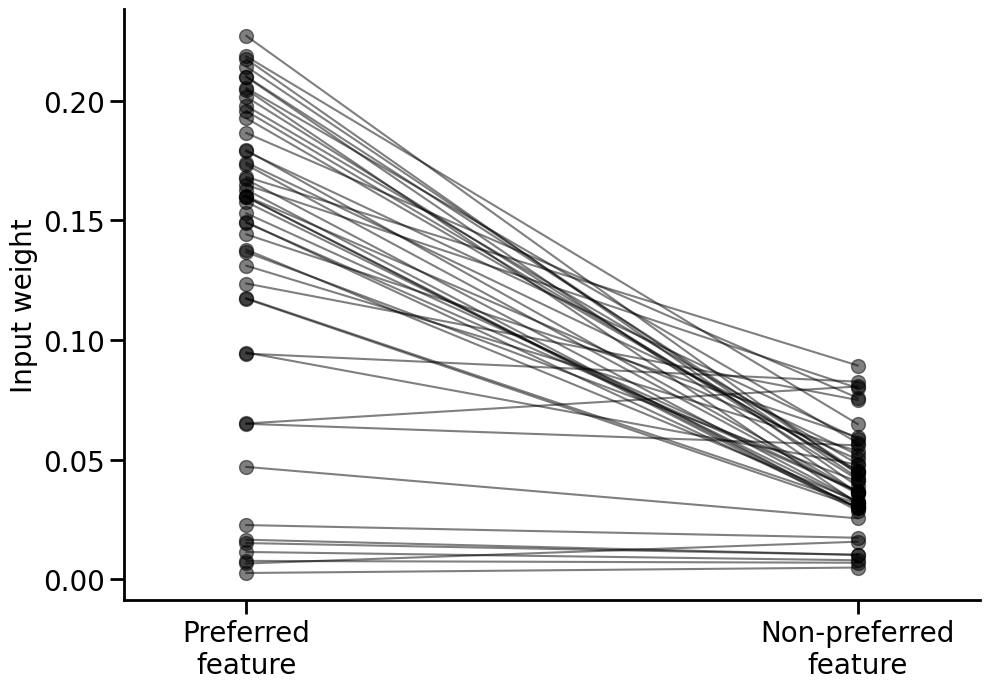

t=9.374152532488573, p-value=2.367495916952123e-15, n=47


In [ ]:
with open('/path/to/processed/data/conn_bias_sm_w_in.pickle', 'rb') as handle:
    all_data = pickle.load(handle)


data_fig5c = {'big': [], 'small': []}

for data in all_data:
    if data['model_name'] != 'success_2023-05-10-14-28-42_wcst_106_sparsity0':    # this is the example model
        continue
    w_in_larges = []
    w_in_large_refs = []
    w_in_large_tests = []
    w_in_smalls = []
    for r in [1, 2]:
        for choice in [1, 2, 3]:
            for card in ['(0, 0)', '(1, 0)', '(0, 1)', '(1, 1)']:
                neuron_id_rule = data['subcg_sr_idx']['rule{}_sr_esoma'.format(r)]
                neuron_id_choice = data['subcg_sr_idx']['respc{}_sr_esoma'.format(choice)]
                neuron_id_refcard = data['subcg_sr_idx']['ref_card{}_sr_esoma'.format(card)]
                neuron_id = [n for n in neuron_id_rule if (n in neuron_id_choice and n in neuron_id_refcard)]    # all neurons that prefer a given combination of rule, choice and reference card (and therefore feature)        
                # print('rule {}, choice {}, card {}\nneuron_id {}'.format(r, choice, card, neuron_id))
                if (r==1 and (card=='(0, 0)' or card=='(0, 1)')) or (r==2 and (card=='(0, 0)' or card=='(1, 0)')):
                    feature_id = 0    # this neuron prefers when the matching feature is blue or circle
                else:
                    feature_id = 1    # this neuron prefers when the matching feature is red or square 
#                 input_neuron_id_large = [2*(r-1) + feature_id, 4+4*(choice-1) + 2*(r-1) + feature_id]    # the indices of the input neurons that should have a strong projection to this neuron
                input_neuron_id_large_ref = 2*(r-1) + feature_id
                input_neuron_id_large_test = 4+4*(choice-1) + 2*(r-1) + feature_id
                input_neuron_id_large = [input_neuron_id_large_ref, input_neuron_id_large_test]    # the indices of the input neurons that should have a strong projection to this neuron
                input_neuron_id_small = [i for i in range(data['w_in_eff'].shape[0]) if i not in input_neuron_id_large]
                for n in neuron_id:
                    dend_id = [n + (b+1)*data['n_sr_esoma'] for b in range(data['n_branches'])]    # the dendritic indices
                    w_in_large = data['w_in_eff'][np.ix_(input_neuron_id_large, dend_id)]
                    w_in_small = data['w_in_eff'][np.ix_(input_neuron_id_small, dend_id)]
                    w_in_large_ref = data['w_in_eff'][input_neuron_id_large_ref, dend_id]
                    w_in_large_test = data['w_in_eff'][input_neuron_id_large_test, dend_id]
                    
                    w_in_larges.append(np.mean(w_in_large))
                    w_in_smalls.append(np.mean(w_in_small))
                    w_in_large_refs.append(np.mean(w_in_large_ref))
                    w_in_large_tests.append(np.mean(w_in_large_test))
                    
    #=== plotting ===#
    fig, ax = plt.subplots(figsize=[10,7])
    fig.patch.set_facecolor('white')
    for i in range(len(w_in_larges)):
        ax.plot([w_in_larges[i], w_in_smalls[i]], marker='o', markersize=10, alpha=0.5, color='k')
    y = [w_in_larges, w_in_smalls]
    
    ax.set_xlim([-0.2, 1.2])
    ax.set_ylabel(r'Input weight', fontsize=20)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Preferred\nfeature', 'Non-preferred\nfeature'], rotation=0, fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()

    
    # statistical test
    t, p = scipy.stats.ttest_ind(y[0], y[1], alternative='greater')
    print('t={}, p-value={}, n={}'.format(t, p, len(y[0])))

    # save source data
    data_fig5c['big'] = w_in_larges
    data_fig5c['small'] = w_in_smalls





# Supplementary figure 9a, b: across all networks

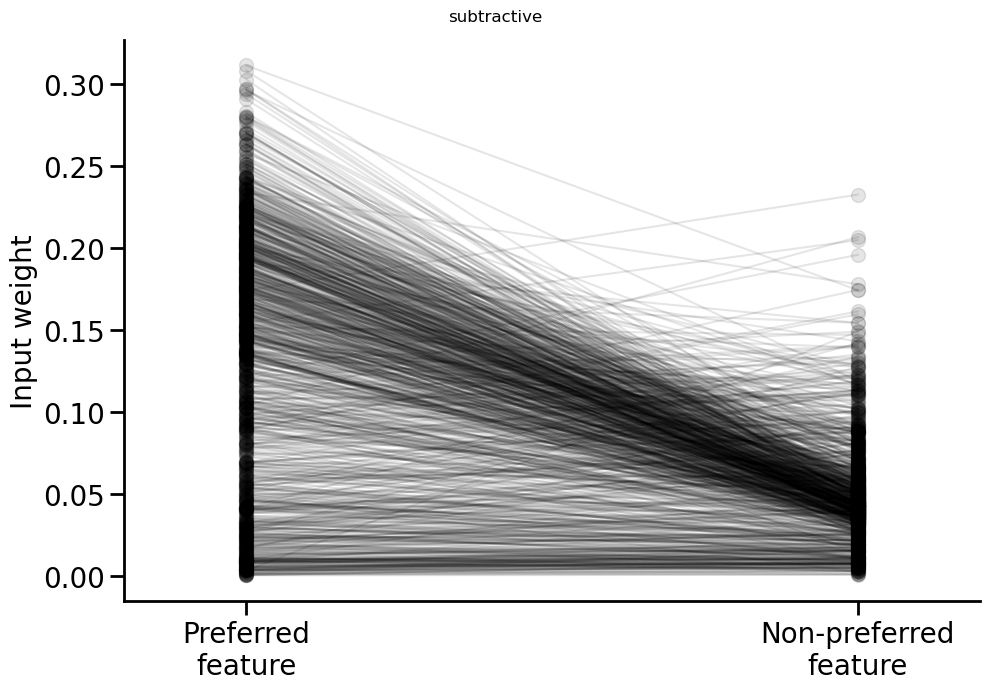

t=32.668675076839754, p-value=4.401821103442721e-189, n=1025


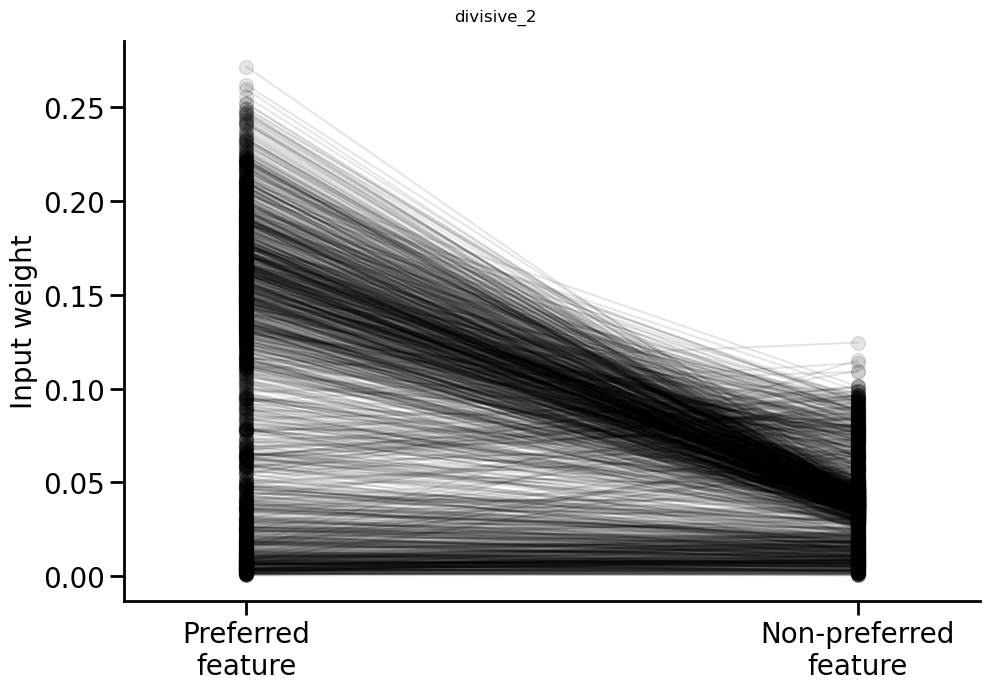

t=39.17691879984322, p-value=1.067618154012433e-270, n=1468


In [4]:
data_suppfig9ab = {'subtractive': {}, 'divisive_2': {}}
for key in data_suppfig9ab.keys():
    data_suppfig9ab[key] = {'big': [], 'small': []}
    
for dend_nonlinear in ['subtractive', 'divisive_2']:
    w_in_large_all_models = []
    w_in_large_ref_all_models = []
    w_in_large_test_all_models = []
    w_in_small_all_models = []
    for data in all_data:
        if data['hp']['dend_nonlinearity'] != dend_nonlinear: 
            continue
        w_in_larges = []
        w_in_large_refs = []
        w_in_large_tests = []
        w_in_smalls = []
        for r in [1, 2]:
            for choice in [1, 2, 3]:
                for card in ['(0, 0)', '(1, 0)', '(0, 1)', '(1, 1)']:
                    neuron_id_rule = data['subcg_sr_idx']['rule{}_sr_esoma'.format(r)]
                    neuron_id_choice = data['subcg_sr_idx']['respc{}_sr_esoma'.format(choice)]
                    neuron_id_refcard = data['subcg_sr_idx']['ref_card{}_sr_esoma'.format(card)]
                    neuron_id = [n for n in neuron_id_rule if (n in neuron_id_choice and n in neuron_id_refcard)]    # all neurons that prefer a given combination of rule, choice and reference card (and therefore feature)        
                    if (r==1 and (card=='(0, 0)' or card=='(0, 1)')) or (r==2 and (card=='(0, 0)' or card=='(1, 0)')):
                        feature_id = 0    # this neuron prefers when the matching feature is blue or circle
                    else:
                        feature_id = 1    # this neuron prefers when the matching feature is red or square 
                    input_neuron_id_large_ref = 2*(r-1) + feature_id
                    input_neuron_id_large_test = 4+4*(choice-1) + 2*(r-1) + feature_id
                    input_neuron_id_large = [input_neuron_id_large_ref, input_neuron_id_large_test]    # the indices of the input neurons that should have a strong projection to this neuron
                    input_neuron_id_small = [i for i in range(data['w_in_eff'].shape[0]) if i not in input_neuron_id_large]
                    for n in neuron_id:
                        dend_id = [n + (b+1)*data['n_sr_esoma'] for b in range(data['n_branches'])]    # the dendritic indices
                        w_in_large = data['w_in_eff'][np.ix_(input_neuron_id_large, dend_id)]
                        w_in_small = data['w_in_eff'][np.ix_(input_neuron_id_small, dend_id)]
                        w_in_large_ref = data['w_in_eff'][input_neuron_id_large_ref, dend_id]
                        w_in_large_test = data['w_in_eff'][input_neuron_id_large_test, dend_id]
                        
                        w_in_larges.append(np.mean(w_in_large))
                        w_in_smalls.append(np.mean(w_in_small))
                        w_in_large_refs.append(np.mean(w_in_large_ref))
                        w_in_large_tests.append(np.mean(w_in_large_test))
    
        w_in_large_all_models.extend(w_in_larges)
        w_in_large_ref_all_models.extend(w_in_large_refs)
        w_in_large_test_all_models.extend(w_in_large_tests)
        w_in_small_all_models.extend(w_in_smalls)
    
    #=== plotting ===#
    fig, ax = plt.subplots(figsize=[10,7])
    fig.suptitle(dend_nonlinear)
    fig.patch.set_facecolor('white')
    for i in range(len(w_in_large_all_models)):
        ax.plot([w_in_large_all_models[i], w_in_small_all_models[i]], marker='o', markersize=10, alpha=0.1, color='k')
    y = [w_in_large_all_models, w_in_small_all_models]
    
    ax.set_xlim([-0.2, 1.2])
    ax.set_ylabel(r'Input weight', fontsize=20)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Preferred\nfeature', 'Non-preferred\nfeature'], rotation=0, fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()

    
    # statistical test
    t, p = scipy.stats.ttest_ind(y[0], y[1], alternative='greater')
    print('t={}, p-value={}, n={}'.format(t, p, len(y[0])))

    # save source data
    data_suppfig9ab[dend_nonlinear]['big'] = w_in_large_all_models
    data_suppfig9ab[dend_nonlinear]['small'] = w_in_small_all_models
    

# Figure 5d: w_out for an example model

/var/folders/wl/qh_kqt7x4lldx3dnln90l7c80000gn/T/ipykernel_66072/2000990927.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  all_data_wout = pickle.load(handle)


success_2023-05-10-14-28-42_wcst_136_sparsity0


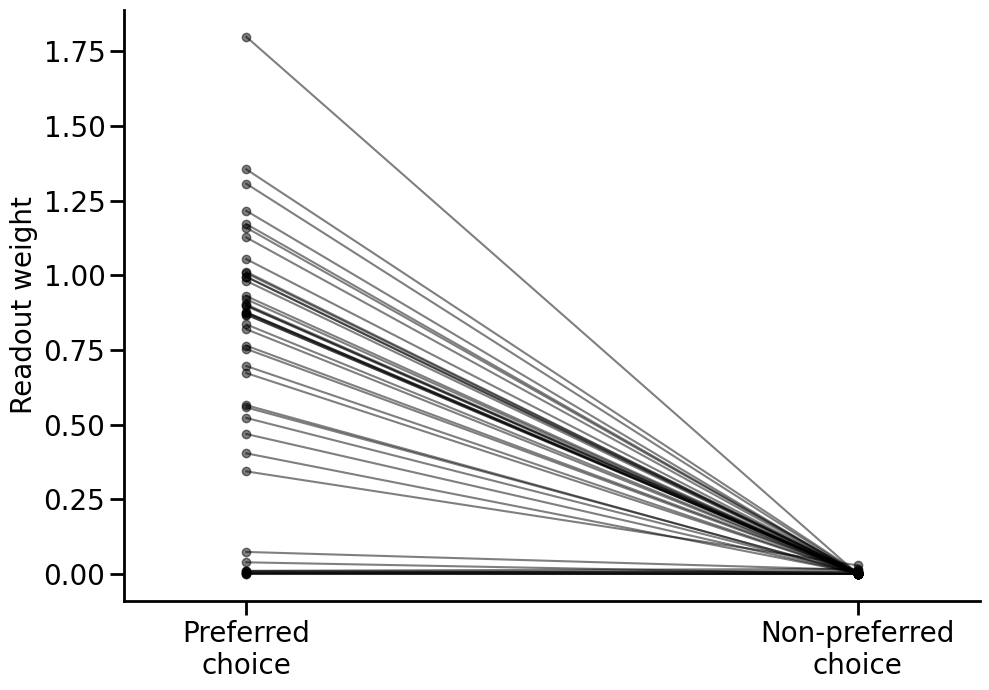

t=10.438550883266116, p-value=2.272226470825055e-17, n=45


In [ ]:
with open('/path/to/processed/data/conn_bias_sm_w_out.pickle', 'rb') as handle:
    all_data_wout = pickle.load(handle)

data_fig5d = {'big': [], 'small': []}

for data in all_data_wout:
    if data['model_name'] != 'success_2023-05-10-14-28-42_wcst_136_sparsity0':    # this is the example model shown in the paper
        continue
    print(data['model_name'])
    wout_pref = []
    wout_nonpref = []
    wout = data['w_out_eff']
    for resp in ['c1', 'c2', 'c3']:
        neuron_idx = data['subcg_sr_idx']['resp{}_sr_esoma'.format(resp)]
        # print('resp {}, neuron_idx {}'.format(resp, neuron_idx))
        if resp=='c1':
            wout_idx_pref, wout_idx_nonpref = 0, [1, 2]
        elif resp=='c2':
            wout_idx_pref, wout_idx_nonpref = 1, [0, 2]
        elif resp=='c3':
            wout_idx_pref, wout_idx_nonpref = 2, [0, 1]
        wout_pref.extend(wout[neuron_idx, wout_idx_pref])
        wout_nonpref.extend(np.mean(wout[np.ix_(neuron_idx, wout_idx_nonpref)], axis=1))

    #===== plotting =====#
    fig, ax = plt.subplots(figsize=[10,7])
    fig.patch.set_facecolor('white')
    ax.plot([0, 1], [wout_pref, wout_nonpref], color='k', marker='o', alpha=0.5)
    ax.set_xlim([-0.2, 1.2])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Preferred\nchoice', 'Non-preferred\nchoice'], rotation=0)
    ax.set_ylabel('Readout weight', fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()

# statistical test
t, p = scipy.stats.ttest_ind(wout_pref, wout_nonpref, alternative='greater')
print('t={}, p-value={}, n={}'.format(t, p, len(wout_pref)))


# collect source data
data_fig5d['big'].extend(wout_pref)
data_fig5d['small'].extend(wout_nonpref)


# Supplementary Figure 9c, d: w_out, across all models

In [ ]:
data_suppfig9cd = {'subtractive': {}, 'divisive_2': {}}
for key in data_suppfig9cd.keys():
    data_suppfig9cd[key] = {'big': [], 'small': []}


for dend_nonlinear in ['subtractive', 'divisive_2']:
    wout_pref_all = []
    wout_nonpref_all = []
    for data in all_data_wout:
        if data['hp']['dend_nonlinearity'] != dend_nonlinear:   
            continue
        # wout_pref = []
        # wout_nonpref = []
        wout = data['w_out_eff']
        for resp in ['c1', 'c2', 'c3']:
            neuron_idx = data['subcg_sr_idx']['resp{}_sr_esoma'.format(resp)]
            if resp=='c1':
                wout_idx_pref, wout_idx_nonpref = 0, [1, 2]
            elif resp=='c2':
                wout_idx_pref, wout_idx_nonpref = 1, [0, 2]
            elif resp=='c3':
                wout_idx_pref, wout_idx_nonpref = 2, [0, 1]
            wout_pref_all.extend(wout[neuron_idx, wout_idx_pref])
            wout_nonpref_all.extend(np.mean(wout[np.ix_(neuron_idx, wout_idx_nonpref)], axis=1))
            
    #===== plotting =====#
    fig, ax = plt.subplots(figsize=[10,7])
    fig.patch.set_facecolor('white')
    ax.plot([0, 1], [wout_pref_all, wout_nonpref_all], color='k', marker='o', alpha=0.1)
    ax.set_xlim([-0.2, 1.2])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Preferred\nchoice', 'Non-preferred\nchoice'], rotation=0)
    ax.set_ylabel('Readout weight', fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()

    # statistical test
    t, p = scipy.stats.ttest_ind(wout_pref_all, wout_nonpref_all, alternative='greater')
    print('t={}, p-value={}, n={}'.format(t, p, len(wout_pref_all)))

    
    # collect source data
    data_suppfig9cd[dend_nonlinear]['big'].extend(wout_pref_all)
    data_suppfig9cd[dend_nonlinear]['small'].extend(wout_nonpref_all)
